## Import

In [122]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## Getting dataset

In [123]:
df = pd.read_csv('./SRC/titanic/train.csv', sep=',')
df_test = pd.read_csv('./SRC/titanic/test.csv', sep=',')
y_test = pd.read_csv('./SRC/titanic/gender_submission.csv', sep=',')

In [124]:
y_test = y_test['Survived']

## Data analisy

First step, delete irrelevant columns

In [125]:
df = df.drop(columns=['PassengerId', 'Name', 'Cabin'])
df_test = df_test.drop(columns=['PassengerId', 'Name', 'Cabin'])

Second step, plots to help analyze the dataset

<AxesSubplot:xlabel='Embarked', ylabel='count'>

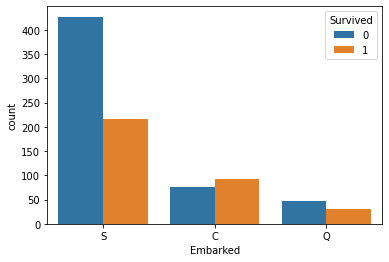

In [126]:
sb.countplot(data=df, x='Embarked', hue='Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

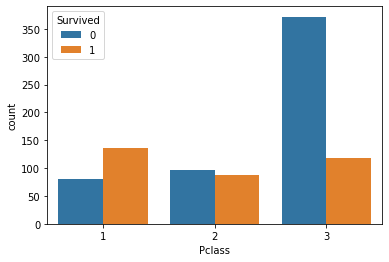

In [127]:
sb.countplot(data=df, x='Pclass', hue='Survived')

<AxesSubplot:xlabel='Sex', ylabel='count'>

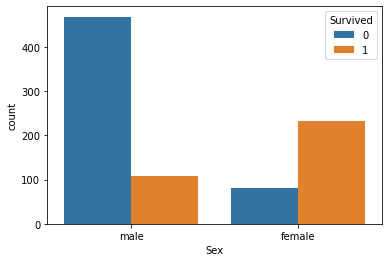

In [128]:
sb.countplot(data=df, x='Sex', hue='Survived')

After some of the analysis, I realized that some data is not as relevant (Fare, Ticket), some data is redundant (Embarked, the difference in the plot is due to some first class passengers boarding at a specific point) and finally the Cabin data are very important, but scarce.

## Data processing

In [129]:
df = df.drop(columns=['Embarked', 'Ticket', 'Fare'])
df_test = df_test.drop(columns=['Embarked', 'Fare', 'Ticket'])

In [130]:
df = df.fillna('0')
df_test = df_test.fillna('0')

In [131]:
labelencoder = LabelEncoder()

df['Sex'] = labelencoder.fit_transform(df['Sex'])
df_test['Sex'] = labelencoder.fit_transform(df_test['Sex'])

In [132]:
X_train, X_test = df.drop(columns=['Survived']), df_test
y_train = df['Survived']

## Training classifiers

### Selecting models and names

In [133]:
models = {
    'knn': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'svc': SVC(),
    'mlp': MLPClassifier(max_iter=500),
    'bayes': GaussianNB()
}

In [134]:
names_models = {
    'knn': 'KNeighborsClassifier',
    'decision_tree': 'DecisionTreeClassifier',
    'random_forest': 'RandomForestClassifier',
    'svc': 'SVC',
    'mlp': 'MLPClassifier',
    'bayes': 'GaussianNB'
}

### Training

In [135]:
accuracies = []
classifiers = []
for i in models:
    clf = models[i].fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(f'Accuracy {names_models[i]} = {accuracy_score(y_test, y_predict)}')
    accuracies.append(accuracy)
    classifiers.append(names_models[i])

Accuracy KNeighborsClassifier = 0.7918660287081339
Accuracy DecisionTreeClassifier = 0.7870813397129187
Accuracy RandomForestClassifier = 0.80622009569378
Accuracy SVC = 0.6363636363636364
Accuracy MLPClassifier = 0.9354066985645934
Accuracy GaussianNB = 0.868421052631579


### Plot results

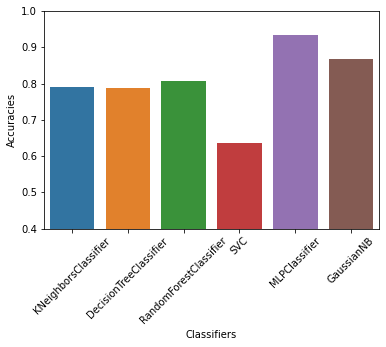

In [136]:
dataframe = pd.DataFrame({
    'Classifiers': classifiers,
    'Accuracies':accuracies
})
ax = sb.barplot(data=dataframe, x='Classifiers', y='Accuracies')
ax.set(ylim=(0.4,1))
ax.tick_params(axis='x', rotation=45)

## Improving classifier

### Selecting best classifiers

In [137]:
models = {
    'knn': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'svc': SVC(),
    'mlp': MLPClassifier(max_iter=500),
}

In [138]:
params = {
    'knn': {'n_neighbors':[1,3,5,7]},
    'decision_tree':{'criterion': ['gini','entropy'], 'splitter':['best', 'random']},
    'random_forest': {'criterion': ['gini','entropy'], 'n_estimators':[50,100,150,200]},
    'svc': {'kernel':['poly', 'rbf', 'sigmoid'], 'degree':[2,3]},
    'mlp': {'solver':['sgd', 'adam'], 'hidden_layer_sizes':[(100,), (50,50), (100,50)], 'max_iter':[1000]},
}

### RandomSearch to find the best classifiers and params

In [139]:
best_accuracy = 0

for i in models:
    clf = GridSearchCV(models[i], params[i]).fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(f'Accuracy {names_models[i]} = {accuracy_score(y_test, y_predict)}')
    print(f'Best params {clf.best_params_}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = clf

Accuracy KNeighborsClassifier = 0.7727272727272727
Best params {'n_neighbors': 7}
Accuracy DecisionTreeClassifier = 0.7894736842105263
Best params {'criterion': 'gini', 'splitter': 'best'}
Accuracy RandomForestClassifier = 0.7990430622009569
Best params {'criterion': 'gini', 'n_estimators': 200}
Accuracy SVC = 0.7057416267942583
Best params {'degree': 3, 'kernel': 'poly'}
Accuracy MLPClassifier = 0.9497607655502392
Best params {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'solver': 'adam'}


## Checking whether normalization and standardization have an effect

In [140]:
X_train_normalized = Normalizer().fit(X_train).transform(X_train)
X_test_normalized = Normalizer().fit(X_test).transform(X_test)
X_train_standard = Normalizer().fit(X_train).transform(X_train)
X_test_standard = Normalizer().fit(X_test).transform(X_test)

In [141]:
model = best_classifier.best_estimator_
model

MLPClassifier(max_iter=1000)

In [142]:
classifiers = ['No alter', 'Normalized', 'Standarlized']
accuracies = []
model.fit(X_train, y_train)
accuracies.append(accuracy_score(y_test, model.predict(X_test)))
model.fit(X_train_normalized, y_train)
accuracies.append(accuracy_score(y_test, model.predict(X_test_normalized)))
model.fit(X_train_standard,y_train)
accuracies.append(accuracy_score(y_test, model.predict(X_test_standard)))

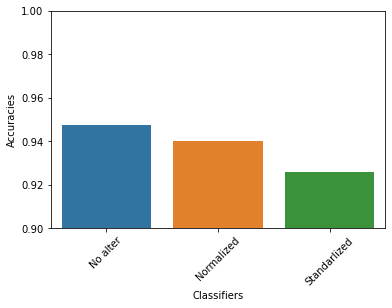

In [143]:
dataframe = pd.DataFrame({
    'Classifiers': classifiers,
    'Accuracies':accuracies
})
ax = sb.barplot(data=dataframe, x='Classifiers', y='Accuracies')
ax.set(ylim=(0.9,1))
ax.tick_params(axis='x', rotation=45)

For this set of data, the classifier gains around 8% to 11% accuracy compared to standardized and normalized data

## Saving best model

In [144]:
import os
save_models_path = './results'
if not os.path.exists(save_models_path):
    os.mkdir(save_models_path)

In [145]:
import joblib
import glob

In [146]:
filename = save_models_path+'/titanic.pkl'
model = model = best_classifier.best_estimator_
model.fit(X_train_normalized, y_train)
joblib.dump(model,filename)

['./results/titanic.pkl']

The 'Normalization' data processing technique was chosen to implement the algorithm, as it has better results in the tests.

In [147]:
modelo_load = joblib.load('./results/titanic.pkl')

In [148]:
accuracy_score(y_test, modelo_load.predict(X_test_normalized))

0.9354066985645934